# Máquinas de Aprendizaje - Tarea 3

* Diego Pérez

## 4) Reconocimiento de gestos

En esta sección se intentará clasificar imágenes correspondientes a letras en lenguaje de señas. Las imágenes son de dataset MNIST, de 28x28 píxeles en escala de grises (1 canal). En total son 25 clases, 27455 ejemplos de entrenamiento y 7172 de pruebas.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

### a) Dataset

La siguiente función carga los datos, para luego separarlos en conjuntos de entrenamiento, validación y pruebas. El conjunto de validación corresponde a 5000 imágenes extraídas del conjunto de entrenamiento.

In [2]:
def load_data(val_size=5000):
    train = pd.read_csv("sign_mnist_train.csv")
    test = pd.read_csv("sign_mnist_test.csv")
    y_tr = train["label"]
    x_tr = train.iloc[:,1:]
    y_t = test["label"]
    x_t = test.iloc[:,1:]
    x_tr, x_v, y_tr, y_v = train_test_split(x_tr, y_tr, test_size=val_size)
    return(x_tr,x_v,x_t,y_tr,y_v,y_t)

In [3]:
x_tr, x_v, x_t, y_tr, y_v , y_t = load_data()

In [4]:
print(x_tr.shape, x_v.shape, x_t.shape)

(22455, 784) (5000, 784) (7172, 784)


Se grafican los primeros 15 ejemplos, con sus clases correspondientes. Se observa que los gestos para algunas letras son muy similares, lo que puede causar problemas al momento de clasificarlas.

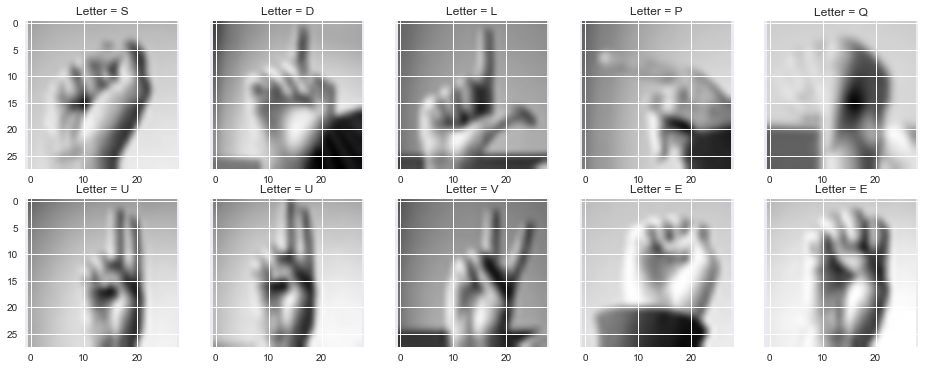

In [73]:
f, axes = plt.subplots(2,5, sharey = True)
f.set_size_inches(16,6)
for i in range(0,10):
    axes[int(i/5)][int(i%5)].axis("equal")
    axes[int(i/5)][int(i%5)].set_title("Letter = " + "ABCDEFGHIJKLMNOPQRSTUVWXYZ"[y_tr.values[i]])
    axes[int(i/5)][int(i%5)].imshow(x_tr.values[i].reshape(28,28), cmap="gray", interpolation="bicubic")

Aunque no se revisó el conjunto de ejemplos completo, se puede esperar que todas las imágenes esten relativamentes centradas, con una iluminación y escala similar.

### b) Preprocessing

En las secciones que siguen se usarán dos escalamientos distintos de los atributos de entrada. El primero corresponde al MinMaxScaler, que deja los valores en el rango (0,1) y StandardScaler, que centra los datos según la media y escala según la desviación estándar.

In [8]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
x_tr_mm = mm_scaler.fit_transform(x_tr)
x_v_mm = mm_scaler.transform(x_v)
x_t_mm = mm_scaler.transform(x_t)

In [9]:
from sklearn.preprocessing import StandardScaler

s_scaler = StandardScaler()
x_tr_s = s_scaler.fit_transform(x_tr)
x_v_s = s_scaler.transform(x_v)
x_t_s = s_scaler.transform(x_t)

### c) Proposed Models

En esta sección se proponen tres topologías distintas de redes neuronales, MLP de una capa escondida, MLP de dos capas escondidas, y convolucional de dos capas convolucionales y una densa. Distintas normalizaciones de los datos se utilizarán durantes las pruebas.

Los hiper-parámetros

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, RMSprop
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV

In [9]:
model1 = Sequential()
model1.add(Dense(30, input_dim=x_tr.shape[1], kernel_initializer="uniform", activation="relu"))
model1.add(Dense(30, kernel_initializer="uniform", activation="relu"))
model1.add(Dense(25, kernel_initializer="uniform", activation="softmax"))
model1.compile(optimizer=SGD(lr=0.05), loss="categorical_crossentropy", metrics=["accuracy"])
model1.fit(x_tr.values, to_categorical(y_tr), epochs=100, batch_size=128, verbose=0,validation_data=(x_v.values,to_categorical(y_v)))

/home/diego/anaconda3/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [32]:
train_score = model1.evaluate(x_tr, to_categorical(y_tr))
val_score = model1.evaluate(x_v, to_categorical(y_v))
test_score = model1.evaluate(x_t, to_categorical(y_t))

print("\nACCURACY\n")
print("Training Set = ", train_score[1])
print("Validation Set = ", val_score[1])
print("Testing Set = ", test_score[1])

7172/7172 [==============================] - 0s 20us/step

ACCURACY

Training Set =  0.0428412380324
Validation Set =  0.04
Testing Set =  0.0401561628555


In [11]:
model2 = Sequential()
model2.add(Dense(100, input_dim=784, kernel_initializer="uniform", activation="sigmoid"))
model2.add(Dense(25, kernel_initializer="uniform", activation="softmax"))
opt = RMSprop(lr=0.001)
model2.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model2.fit(x_tr_mm, to_categorical(y_tr), epochs=200, batch_size=64, verbose=0, validation_data=(x_v_mm, to_categorical(y_v)))

In [31]:
train_score = model2.evaluate(x_tr_mm, to_categorical(y_tr))
val_score = model2.evaluate(x_v_mm, to_categorical(y_v))
test_score = model2.evaluate(x_t_mm, to_categorical(y_t))

print("\nACCURACY\n")
print("Training Set = ", train_score[1])
print("Validation Set = ", val_score[1])
print("Testing Set = ", test_score[1])

7172/7172 [==============================] - 0s 16us/step

ACCURACY

Training Set =  1.0
Validation Set =  1.0
Testing Set =  0.753346346905


In [15]:
from keras.layers import Dropout

model3 = Sequential()
model3.add(Dense(64, input_dim=784, activation="relu"))
model3.add(Dense(64, activation="relu"))
model3.add(Dropout(0))
model3.add(Dense(25, activation="softmax"))
opt = SGD(lr=0.1)
model3.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model3.fit(x_tr_mm, to_categorical(y_tr), epochs=200, batch_size=64, verbose=0, validation_data=(x_v_mm, to_categorical(y_v)))

In [30]:
train_score = model3.evaluate(x_tr_mm, to_categorical(y_tr))
val_score = model3.evaluate(x_v_mm, to_categorical(y_v))
test_score = model3.evaluate(x_t_mm, to_categorical(y_t))

print("\nACCURACY\n")
print("Training Set = ", train_score[1])
print("Validation Set = ", val_score[1])
print("Testing Set = ", test_score[1])

7172/7172 [==============================] - 0s 13us/step

ACCURACY

Training Set =  1.0
Validation Set =  1.0
Testing Set =  0.802426101506


In [19]:
model4 = Sequential()
model4.add(Dense(30, input_dim=x_tr.shape[1], kernel_initializer="uniform", activation="relu"))
model4.add(Dense(30, kernel_initializer="uniform", activation="relu"))
model4.add(Dense(25, kernel_initializer="uniform", activation="softmax"))
model4.compile(optimizer=SGD(lr=0.05), loss="categorical_crossentropy", metrics=["accuracy"])
model4.fit(x_tr_s, to_categorical(y_tr), epochs=100, batch_size=128, verbose=0,validation_data=(x_v_s,to_categorical(y_v)))

In [29]:
train_score = model4.evaluate(x_tr_s, to_categorical(y_tr))
val_score = model4.evaluate(x_v_s, to_categorical(y_v))
test_score = model4.evaluate(x_t_s, to_categorical(y_t))

print("\nACCURACY\n")
print("Training Set = ", train_score[1])
print("Validation Set = ", val_score[1])
print("Testing Set = ", test_score[1])

7172/7172 [==============================] - 0s 12us/step

ACCURACY

Training Set =  1.0
Validation Set =  1.0
Testing Set =  0.70928611266


In [21]:
model5 = Sequential()
model5.add(Dense(100, input_dim=784, kernel_initializer="uniform", activation="sigmoid"))
model5.add(Dense(25, kernel_initializer="uniform", activation="softmax"))
opt = RMSprop(lr=0.001)
model5.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model5.fit(x_tr_s, to_categorical(y_tr), epochs=200, batch_size=64, verbose=0, validation_data=(x_v_s, to_categorical(y_v)))

In [28]:
train_score = model5.evaluate(x_tr_s, to_categorical(y_tr))
val_score = model5.evaluate(x_v_s, to_categorical(y_v))
test_score = model5.evaluate(x_t_s, to_categorical(y_t))

print("\nACCURACY\n")
print("Training Set = ", train_score[1])
print("Validation Set = ", val_score[1])
print("Testing Set = ", test_score[1])

7172/7172 [==============================] - 0s 17us/step

ACCURACY

Training Set =  1.0
Validation Set =  1.0
Testing Set =  0.742470719465


In [33]:
from keras.layers import Dropout

model6 = Sequential()
model6.add(Dense(64, input_dim=784, activation="relu"))
model6.add(Dense(64, activation="relu"))
model6.add(Dropout(0))
model6.add(Dense(25, activation="softmax"))
opt = SGD(lr=0.1)
model6.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model6.fit(x_tr_s, to_categorical(y_tr), epochs=200, batch_size=64, verbose=0, validation_data=(x_v_s, to_categorical(y_v)))

In [34]:
train_score = model6.evaluate(x_tr_s, to_categorical(y_tr))
val_score = model6.evaluate(x_v_s, to_categorical(y_v))
test_score = model6.evaluate(x_t_s, to_categorical(y_t))

print("\nACCURACY\n")
print("Training Set = ", train_score[1])
print("Validation Set = ", val_score[1])
print("Testing Set = ", test_score[1])

7172/7172 [==============================] - 0s 30us/step

ACCURACY

Training Set =  1.0
Validation Set =  1.0
Testing Set =  0.772308979364


In [9]:
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam

In [15]:
x_tr_mm_c = x_tr_mm.reshape(-1,28,28,1)
x_v_mm_c = x_v_mm.reshape(-1,28,28,1)
x_t_mm_c = x_t_mm.reshape(-1,28,28,1)

model7 = Sequential()
model7.add(Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)))
model7.add(BatchNormalization(axis=-1, center=False))
model7.add(Conv2D(32, (7,7), activation='relu'))
model7.add(BatchNormalization(axis=-1, center=False))
model7.add(MaxPooling2D(2,2))
model7.add(Flatten())
model7.add(Dense(64, activation='relu'))
model7.add(BatchNormalization(center=False))
model7.add(Dropout(0.2))
model7.add(Dense(25, activation='softmax'))
opt = Adam(lr=0.01)
model7.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

model7.fit(x_tr_mm_c, to_categorical(y_tr), epochs=15, batch_size=64, verbose=0, validation_data=(x_v_mm_c, to_categorical(y_v)))

In [40]:
train_score = model7.evaluate(x_tr_mm_c, to_categorical(y_tr))
val_score = model7.evaluate(x_v_mm_c, to_categorical(y_v))
test_score = model7.evaluate(x_t_mm_c, to_categorical(y_t))

print("\nACCURACY\n")
print("Training Set = ", train_score[1])
print("Validation Set = ", val_score[1])
print("Testing Set = ", test_score[1])

7172/7172 [==============================] - 16s 2ms/step

ACCURACY

Training Set =  0.999421064351
Validation Set =  0.9994
Testing Set =  0.90490797546


In [17]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
            zoom_range=0.2, # randomly zoom into images
#           rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)

In [19]:
x_tr_mm_c = x_tr_mm.reshape(-1,28,28,1)
x_v_mm_c = x_v_mm.reshape(-1,28,28,1)
x_t_mm_c = x_t_mm.reshape(-1,28,28,1)

model7.fit_generator(data_gen.flow(x_tr_mm_c, to_categorical(y_tr), batch_size=128), 
           steps_per_epoch=int(np.ceil(x_tr_mm_c.shape[0]/128.0)),
           epochs = 15,
           verbose=0,
           workers=4)

In [20]:
train_score = model7.evaluate(x_tr_mm_c, to_categorical(y_tr))
val_score = model7.evaluate(x_v_mm_c, to_categorical(y_v))
test_score = model7.evaluate(x_t_mm_c, to_categorical(y_t))

print("\nACCURACY\n")
print("Training Set = ", train_score[1])
print("Validation Set = ", val_score[1])
print("Testing Set = ", test_score[1])

7172/7172 [==============================] - 13s 2ms/step

ACCURACY

Training Set =  0.995101313739
Validation Set =  0.9932
Testing Set =  0.972113775795


### d) Classification report

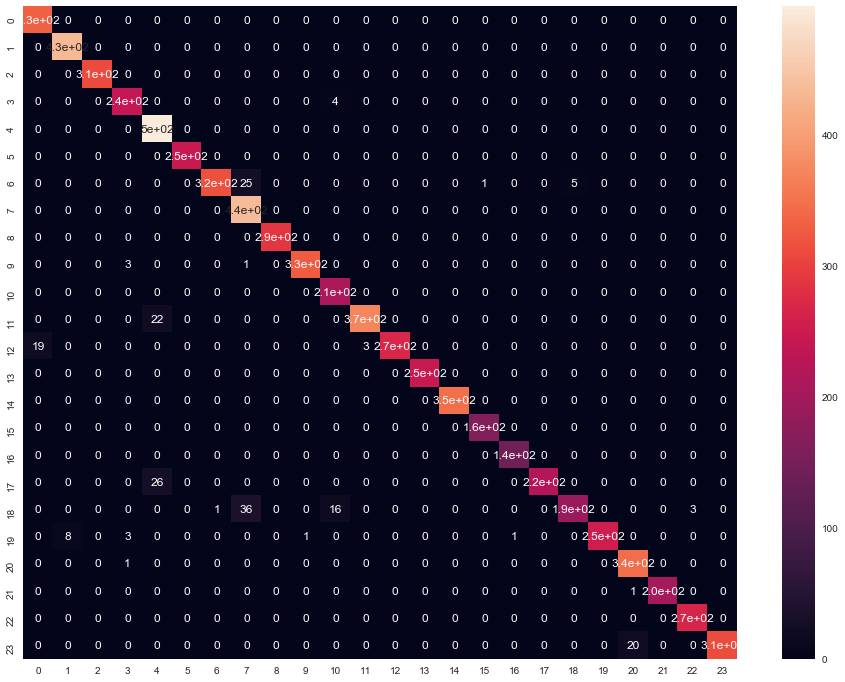

In [79]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_t, model7.predict(x_t_mm_c).argmax(1))
df_cm = pd.DataFrame(cm, range(24), range(24))
plt.figure(figsize=(16,12))
sn.set(font_scale=1) #for label size
sn.heatmap(cm, annot=True,annot_kws={"size": 12}) # font size

In [56]:
y_pred = model7.predict(x_t_mm_c).argmax(1)
diff = y_t.values - y_pred
indexes = np.asarray(np.nonzero(diff)).flatten()

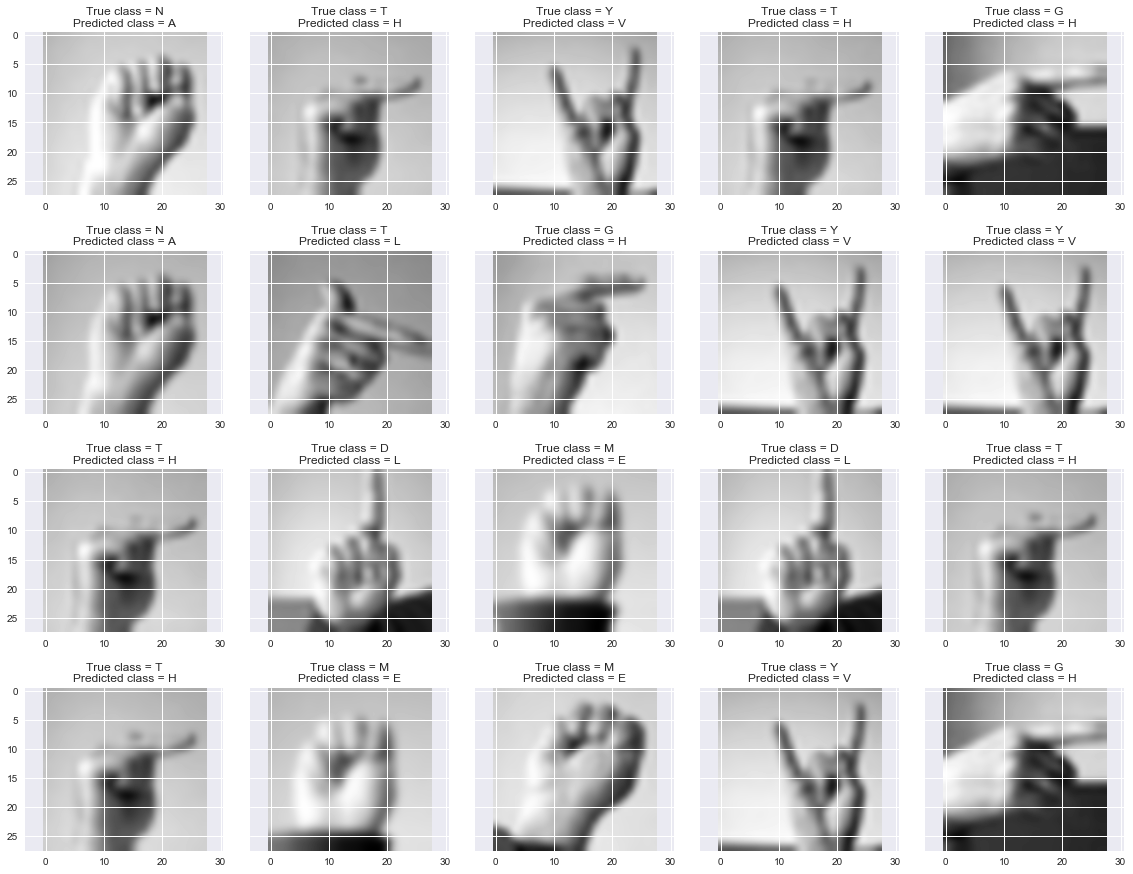

In [78]:
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
f, axes = plt.subplots(4,5, sharey = True)
f.set_size_inches(16,12)
f.tight_layout(h_pad=3)
for i in range(0,20):
    axes[int(i/5)][int(i%5)].axis("equal")
    axes[int(i/5)][int(i%5)].set_title("True class = {}\nPredicted class = {}".format(letters[y_t.values[indexes[i]]], letters[y_pred[indexes[i]]]))
    axes[int(i/5)][int(i%5)].imshow((x_t.values[indexes[i]]).reshape(28,28), cmap="gray", interpolation="bicubic")

### e) SVM

In [6]:
from sklearn.svm import SVC

clf = SVC(kernel="poly", C=100)
clf.fit(x_tr, y_tr)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [7]:
test_score = clf.score(x_t, y_t)
print(test_score)

0.789180145008


In [10]:
clf = SVC(kernel="rbf", C=100)
clf.fit(x_tr_mm, y_tr)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
test_score = clf.score(x_t_mm, y_t)
print(test_score)

0.792665923034


In [12]:
clf = SVC(kernel="rbf", C=100)
clf.fit(x_tr_s, y_tr)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
test_score = clf.score(x_t_s, y_t)
print(test_score)

0.848717233687


### f) Árbol de clasificación

In [15]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=40)
clf.fit(x_tr, y_tr)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=40,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
test_score = clf.score(x_t, y_t)
print(test_score)

0.449107640825


In [17]:
clf = DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=20)
clf.fit(x_tr_mm, y_tr)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
test_score = clf.score(x_t_mm, y_t)
print(test_score)

0.452732849972


In [19]:
clf = DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=20)
clf.fit(x_tr_s, y_tr)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
test_score = clf.score(x_t_s, y_t)
print(test_score)

0.450362520915
